#GNN Models

**Global Variables/Imports**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import os

BUFFER_SIZE = 60000
BATCH_SIZE = 256
LEARNING_RATE = 0.0002
BETA_1 = 0.5
EPOCHS = 30

#**DCGAN**

In [2]:
def load_data():
    (X_train, y_train), (_, _) = cifar10.load_data()
    X_train = (X_train.astype('float32') - 127.5) / 127.5
    y_train = y_train.astype('int32')
    return X_train, y_train

In [4]:
def make_generator_model_with_text():
    noise_input = layers.Input(shape=(100,))
    text_input = layers.Input(shape=(119,))

    text_emb = layers.Dense(256, activation='relu')(text_input)
    concatenated_input = layers.Concatenate()([noise_input, text_emb])

    x = layers.Dense(4*4*512, use_bias=False)(concatenated_input)
    x = layers.Reshape((4, 4, 512))(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(256, 5, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(128, 5, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(3, 5, strides=2, padding='same', use_bias=False)(x)
    out = layers.Activation('tanh')(x)

    return models.Model(inputs=[noise_input, text_input], outputs=out)

def make_discriminator_model_with_text():
    image_input = layers.Input(shape=(32, 32, 3))
    text_input = layers.Input(shape=(119,))

    text_emb = layers.Dense(8 * 8 * 256, activation='relu')(text_input)
    text_emb = layers.Reshape((8, 8, 256))(text_emb)
    tiled_emb = layers.UpSampling2D(size=(4, 4))(text_emb)

    x = layers.Conv2D(64, 5, strides=1, padding='same')(image_input)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(128, 5, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(256, 5, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.LeakyReLU(0.2)(x)

    concatenated_features = layers.Concatenate()([x, tiled_emb])

    x = layers.Conv2D(512, 1, strides=(1, 1))(concatenated_features)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Flatten()(x)
    out = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs=[image_input, text_input], outputs=out)




In [ ]:

generator_optimizer = optimizers.Adam(LEARNING_RATE, BETA_1)
discriminator_optimizer = optimizers.Adam(LEARNING_RATE, BETA_1)

cross_entropy = losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

@tf.function
def train_step(images, labels, generator, discriminator, generator_optimizer, discriminator_optimizer):
    BATCH_SIZE = tf.shape(images)[0]
    noise = tf.random.normal([BATCH_SIZE, 100])

    one_hot_labels = tf.one_hot(labels, depth=119)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, one_hot_labels], training=True)

        real_output = discriminator([images, one_hot_labels], training=True)
        fake_output = discriminator([generated_images, one_hot_labels], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss



def train(dataset, epochs, generator, discriminator):
    gen_loss_log = []
    disc_loss_log = []
    for epoch in range(epochs):
        epoch_gen_loss = []
        epoch_disc_loss = []
        for image_batch, text_batch in dataset:
            text_batch = tf.squeeze(text_batch, axis=-1)
            gen_loss, disc_loss = train_step(image_batch, text_batch, generator, discriminator, generator_optimizer, discriminator_optimizer)
            epoch_gen_loss.append(gen_loss.numpy())
            epoch_disc_loss.append(disc_loss.numpy())
        gen_loss_log.extend(epoch_gen_loss)
        disc_loss_log.extend(epoch_disc_loss)
        print(f"Epoch {epoch+1}, Gen Loss: {gen_loss}, Disc Loss: {disc_loss}")

    plt.figure(figsize=(10, 5))
    plt.plot(gen_loss_log, label='Generator Loss')
    plt.plot(disc_loss_log, label='Discriminator Loss')
    plt.title('Training Losses')
    plt.ylabel('Loss')
    plt.xlabel('Batch')
    plt.legend()
    plt.show()

X_train, y_train = load_data()
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

generator = make_generator_model_with_text()
discriminator = make_discriminator_model_with_text()

train(dataset, EPOCHS, generator, discriminator)


**Produce 10 Output Images**

In [ ]:
def generate_and_save_images(model, discriminator, epoch, test_input, test_labels, num_images=10):
    predictions = model([test_input, test_labels], training=False)
    fig = plt.figure(figsize=(10, 10))

    valid, _ = discriminator(predictions, training=False)
    scores = valid.numpy()
    best_indices = np.argsort(scores.flatten())[:num_images]

    for i in range(num_images):
        plt.subplot(num_images // 5, 5, i+1)
        plt.imshow(predictions[best_indices[i], :, :, :] * 0.5 + 0.5)
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

num_examples_to_generate = 10
seed = tf.random.normal([num_examples_to_generate, 100])

random_labels = tf.random.uniform([num_examples_to_generate, 1], minval=0, maxval=10, dtype=tf.int32)

generate_and_save_images(generator, discriminator, EPOCHS, seed, random_labels)

#**WGAN**

In [ ]:
def load_data():
    (X_train, _), (_, _) = cifar10.load_data()
    X_train = (X_train.astype('float32') - 127.5) / 127.5
    return X_train

In [7]:
def make_generator_model():
    noise_input = layers.Input(shape=(100,))
    x = layers.Dense(4*4*512, use_bias=False)(noise_input)
    x = layers.Reshape((4, 4, 512))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(256, 5, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(128, 5, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(3, 5, strides=2, padding='same', use_bias=False)(x)
    out = layers.Activation('tanh')(x)

    return models.Model(inputs=noise_input, outputs=out)

def make_discriminator_model():
    image_input = layers.Input(shape=(32, 32, 3))
    x = layers.Conv2D(64, 5, strides=2, padding='same')(image_input)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, 5, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(256, 5, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Flatten()(x)
    out = layers.Dense(1)(x)

    return models.Model(inputs=image_input, outputs=out)


Epoch 1, Gen Loss: 0.0018099629087373614, Disc Loss: -0.0023160541895776987
Epoch 2, Gen Loss: 0.003636747132986784, Disc Loss: -0.007109120022505522
Epoch 3, Gen Loss: 0.008116624318063259, Disc Loss: -0.00693934503942728
Epoch 4, Gen Loss: 0.02021164447069168, Disc Loss: -0.025382641702890396
Epoch 5, Gen Loss: 0.07129562646150589, Disc Loss: -0.0854361280798912
Epoch 6, Gen Loss: 0.1422318071126938, Disc Loss: -0.148653045296669
Epoch 7, Gen Loss: 0.06692399084568024, Disc Loss: -0.11321528255939484
Epoch 8, Gen Loss: 0.012870123609900475, Disc Loss: -0.05364096164703369
Epoch 9, Gen Loss: -0.07661452889442444, Disc Loss: 0.00619044154882431
Epoch 10, Gen Loss: 0.028979286551475525, Disc Loss: -0.08834398537874222
Epoch 11, Gen Loss: 0.10024145245552063, Disc Loss: -0.17603613436222076
Epoch 12, Gen Loss: 0.09204494208097458, Disc Loss: -0.13537998497486115
Epoch 13, Gen Loss: 0.007891019806265831, Disc Loss: -0.07793473452329636
Epoch 14, Gen Loss: 0.03312545269727707, Disc Loss: -

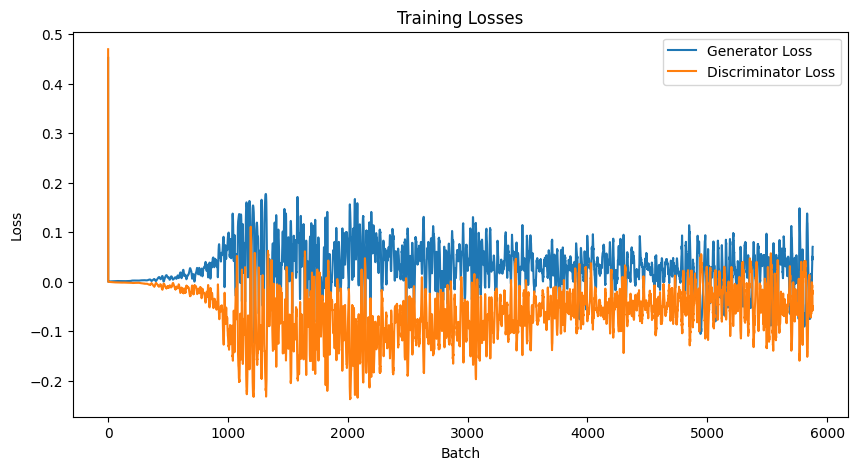

In [13]:
generator_optimizer = optimizers.Adam(LEARNING_RATE, BETA_1)
discriminator_optimizer = optimizers.Adam(LEARNING_RATE, BETA_1)

cross_entropy = losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)


def train_step(images, generator, discriminator):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        # Weight clipping for discriminator in WGAN
        for var in discriminator.trainable_variables:
            var.assign(tf.clip_by_value(var, -0.01, 0.01))

    return gen_loss, disc_loss

def train(dataset, epochs, generator, discriminator):
    gen_loss_log = []
    disc_loss_log = []
    for epoch in range(epochs):
        epoch_gen_loss = []
        epoch_disc_loss = []
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, generator, discriminator)
            epoch_gen_loss.append(gen_loss.numpy())
            epoch_disc_loss.append(disc_loss.numpy())
        gen_loss_log.extend(epoch_gen_loss)
        disc_loss_log.extend(epoch_disc_loss)
        print(f"Epoch {epoch+1}, Gen Loss: {gen_loss}, Disc Loss: {disc_loss}")

    plt.figure(figsize=(10, 5))
    plt.plot(gen_loss_log, label='Generator Loss')
    plt.plot(disc_loss_log, label='Discriminator Loss')
    plt.title('Training Losses')
    plt.ylabel('Loss')
    plt.xlabel('Batch')
    plt.legend()
    plt.show()

X_train = load_data()
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

generator = make_generator_model()
discriminator = make_discriminator_model()

train(dataset, EPOCHS, generator, discriminator)

**Produce 10 Output Images**

In [ ]:
def generate_and_save_images(model, discriminator, epoch, test_input, num_images=10):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10, 10))

    scores = discriminator(predictions, training=False).numpy()
    best_indices = np.argsort(scores.flatten())[:num_images]

    for i in range(predictions.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(predictions[i, :, :, :] * 0.5 + 0.5)
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

seed = tf.random.normal([10, 100])

generate_and_save_images(generator, discriminator, EPOCHS, seed)

#**ACGAN**

In [54]:
def load_data():
    (X_train, y_train), (_, _) = cifar10.load_data()
    X_train = (X_train.astype('float32') - 127.5) / 127.5
    y_train = y_train.astype('int32')
    return X_train, y_train


Epoch 1, Gen Loss: 1.1533300876617432, Disc Loss: 2.9281938076019287
Epoch 2, Gen Loss: 0.8361543416976929, Disc Loss: 3.162726402282715
Epoch 3, Gen Loss: 0.9407342076301575, Disc Loss: 2.7702383995056152
Epoch 4, Gen Loss: 0.8230699300765991, Disc Loss: 2.736826181411743
Epoch 5, Gen Loss: 0.8059697151184082, Disc Loss: 2.7313990592956543
Epoch 6, Gen Loss: 0.7810916304588318, Disc Loss: 2.783310890197754
Epoch 7, Gen Loss: 0.7673048377037048, Disc Loss: 2.906902313232422
Epoch 8, Gen Loss: 0.7908501029014587, Disc Loss: 2.5876331329345703
Epoch 9, Gen Loss: 0.7287164330482483, Disc Loss: 2.7400336265563965
Epoch 10, Gen Loss: 0.7319328784942627, Disc Loss: 2.492309808731079
Epoch 11, Gen Loss: 0.7649067640304565, Disc Loss: 2.4492106437683105
Epoch 12, Gen Loss: 0.7312132716178894, Disc Loss: 2.6540398597717285
Epoch 13, Gen Loss: 0.722058117389679, Disc Loss: 2.6394500732421875
Epoch 14, Gen Loss: 0.7412264943122864, Disc Loss: 2.2169888019561768
Epoch 15, Gen Loss: 0.7401917576789

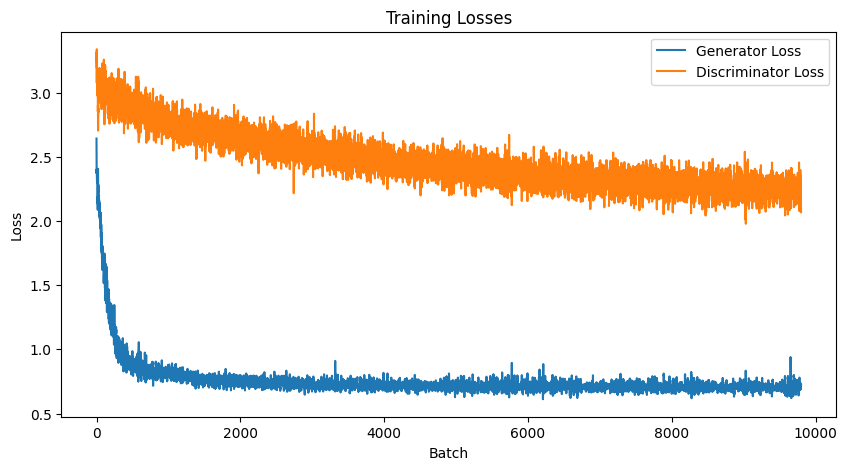

In [34]:
def make_acgan_generator():
    noise = layers.Input(shape=(100,))
    label = layers.Input(shape=(1,), dtype='int32')
    label_embedding = layers.Embedding(10, 100, input_length=1)(label)
    label_embedding = layers.Flatten()(label_embedding)

    model_input = layers.multiply([noise, label_embedding])

    x = layers.Dense(4*4*256, use_bias=False)(model_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((4, 4, 256))(x)

    x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

    model = models.Model([noise, label], x)
    return model

def make_acgan_discriminator():
    image_input = layers.Input(shape=(32, 32, 3))
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(image_input)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    valid = layers.Dense(1, activation='sigmoid')(x)
    label = layers.Dense(10, activation='softmax')(x)

    model = models.Model(image_input, [valid, label])
    return model

generator = make_acgan_generator()
discriminator = make_acgan_discriminator()

generator_optimizer = optimizers.Adam(LEARNING_RATE, BETA_1)
discriminator_optimizer = optimizers.Adam(LEARNING_RATE, BETA_1)

binary_crossentropy = losses.BinaryCrossentropy(from_logits=True)
sparse_categorical_crossentropy = losses.SparseCategoricalCrossentropy(from_logits=True)

@tf.function
def train_step(images, labels):
    noise = tf.random.normal([images.shape[0], 100])
    sampled_labels = tf.random.uniform([images.shape[0], 1], minval=0, maxval=10, dtype=tf.int32)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, sampled_labels], training=True)

        real_output, real_aux = discriminator(images, training=True)
        fake_output, fake_aux = discriminator(generated_images, training=True)

        gen_loss = binary_crossentropy(tf.ones_like(fake_output), fake_output) + \
                   sparse_categorical_crossentropy(sampled_labels, fake_aux)

        disc_loss = binary_crossentropy(tf.ones_like(real_output), real_output) + \
                    binary_crossentropy(tf.zeros_like(fake_output), fake_output) + \
                    sparse_categorical_crossentropy(labels, real_aux)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


def train(dataset, epochs, generator, discriminator):
    gen_loss_log = []
    disc_loss_log = []
    for epoch in range(epochs):
        for (images, labels) in dataset:
            sampled_labels = tf.random.uniform([images.shape[0], 1], minval=0, maxval=10, dtype=tf.int32)
            gen_loss, disc_loss = train_step(images, labels)
            gen_loss_log.append(gen_loss.numpy())
            disc_loss_log.append(disc_loss.numpy())
        print(f"Epoch {epoch+1}, Gen Loss: {gen_loss}, Disc Loss: {disc_loss}")

    plt.figure(figsize=(10, 5))
    plt.plot(gen_loss_log, label='Generator Loss')
    plt.plot(disc_loss_log, label='Discriminator Loss')
    plt.title('Training Losses')
    plt.ylabel('Loss')
    plt.xlabel('Batch')
    plt.legend()
    plt.show()


X_train, y_train = load_data()
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

w
for image_batch in dataset:
    images, labels = image_batch
    sampled_labels = tf.random.uniform([BATCH_SIZE, 1], minval=0, maxval=10, dtype=tf.int32)
    gen_loss, disc_loss = train_step(images, labels)

train(dataset, EPOCHS, generator, discriminator)

**Produce 10 Output Images**

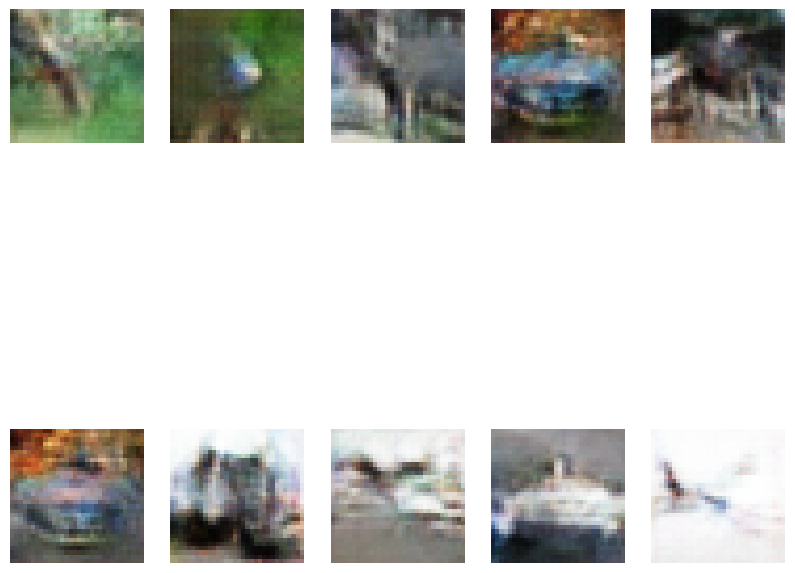

In [38]:
def generate_and_save_images(model, discriminator, epoch, test_input, test_labels, num_images=10):
    predictions = model([test_input, test_labels], training=False)
    fig = plt.figure(figsize=(10, 10))

    valid, _ = discriminator(predictions, training=False)
    scores = valid.numpy()
    best_indices = np.argsort(scores.flatten())[:num_images]

    for i in range(num_images):
        plt.subplot(num_images // 5, 5, i+1)
        plt.imshow(predictions[best_indices[i], :, :, :] * 0.5 + 0.5)
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

num_examples_to_generate = 10
seed = tf.random.normal([num_examples_to_generate, 100])

random_labels = tf.random.uniform([num_examples_to_generate, 1], minval=0, maxval=10, dtype=tf.int32)

generate_and_save_images(generator, discriminator, EPOCHS, seed, random_labels)